# Label-free prediction of white blood cells

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

In [4]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"

In [17]:
df = pq.read_table(data_dir / f"results/scip/202210011434/features.parquet").to_pandas()

In [18]:
cols = numpy.load(data_dir / "results/scip/202210011434/columns.npy", allow_pickle=True)
df = df[cols]

index = numpy.load(data_dir / "results/scip/202210011434/index.npy", allow_pickle=True)
df = df.loc[index]

df.shape

(255900, 2615)

In [19]:
def predict_gates(X, y, model, seed=42):
    numpy.random.seed(seed)
    
    scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
    cv_results = cross_validate(
        estimator=model,
        X=X.values, y=y, cv=5,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
        n_jobs=5,
        verbose=0
    )
    cv_df = pandas.DataFrame(
        data = {
            **{"phase": ["train"] * 5 + ["test"] * 5},
            **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
        }
    ).melt(id_vars=["phase"])
    seaborn.stripplot(data=cv_df, y="variable", x="value", hue="phase", jitter=0)
    return cv_df

<AxesSubplot:xlabel='meta_label', ylabel='count'>

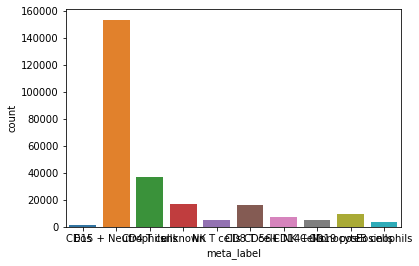

In [21]:
seaborn.countplot(x=df["meta_label"])

In [22]:
neuts = df[df["meta_label"] == "CD15 + Neutrophils"].sample(n=120000).index

In [23]:
df = df.drop(labels=neuts)

<AxesSubplot:xlabel='meta_label', ylabel='count'>

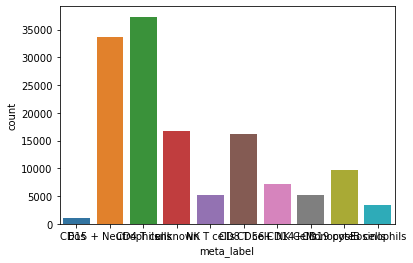

In [24]:
seaborn.countplot(x=df["meta_label"])

In [25]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

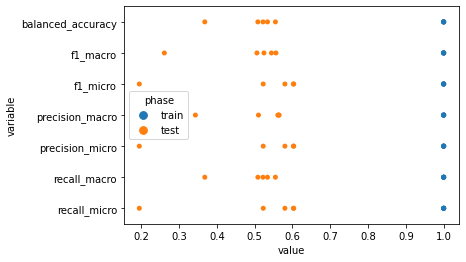

In [26]:
from sklearn import tree
model = tree.DecisionTreeClassifier(class_weight="balanced")
_ = predict_gates(
    df.filter(regex="(BF1|BF2|SSC)$"), y, 
    model
)